In [4]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import holidays

In [6]:
train_df = pd.read_csv("train.csv")
gas_df = pd.read_csv("gas_prices.csv")
electricity_df = pd.read_csv("electricity_prices.csv")
client_df = pd.read_csv("client.csv")
fw_df = pd.read_csv("forecast_weather.csv")
hw_df = pd.read_csv("historical_weather.csv")
location = pd.read_csv("county_lon_lats.csv")
location = location.drop(columns = ["Unnamed: 0"])

In [ ]:
monthly = hw_df.groupby(pd.Grouper(key="datetime", freq='M')).mean() 
weekly = hw_df.groupby(pd.Grouper(key="datetime", freq='W')).mean() 
daily = hw_df.groupby(pd.Grouper(key="datetime", freq='D')).mean() 
meanTemp = hw_df.temperature.mean()
meanSolar = hw_df.direct_solar_radiation.mean()
meanRain = hw_df.rain.mean()
meanSnow = hw_df.snowfall.mean()
meanWindspeed = hw_df.windspeed_10m.mean()
meanSurfacePressure = hw_df.surface_pressure.mean()

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily, x=daily.index, y="temperature", color='#C59279')
plt.title('Daily Historical Temperature Analysis')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.axhline(y=meanTemp, linestyle='--', color='red', label='Average Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily[['direct_solar_radiation', 'shortwave_radiation']])
plt.title('Daily Radiation Analysis')
plt.xlabel('Date')
plt.ylabel('Radiation Level')
plt.axhline(y=meanSolar, linestyle='--', color='red', label='Average Solar Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily[['rain', 'snowfall']], palette=["#325288", "pink"], linewidth=2.5)
plt.title('Daily Rain/Snowfall Analysis')
plt.xlabel('Date')
plt.ylabel('Rain/Snow Level')
plt.axhline(y=meanRain, linestyle='--', color='red', label='Average Rainfall')
plt.axhline(y=meanSnow, linestyle='--', color='yellow', label='Average Snowfall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily['windspeed_10m'], color="#69C98D", linewidth=2.5)
plt.title('Daily Windspeed Analysis')
plt.xlabel('Date')
plt.ylabel('Windspeed (in m/s)')
plt.axhline(y=meanWindspeed, linestyle='--', color='red', label='Average Windspeed')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily['surface_pressure'], color="#D61640", linewidth=2.5)
plt.title('Daily Surface Pressure Analysis')
plt.xlabel('Date')
plt.ylabel('Pressure (in Hectopascals)')
plt.ylim(900, 1100)  # Set y-axis range
plt.axhline(y=meanSurfacePressure, linestyle='--', color='red', label='Average Surface Pressure')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

def get_holiday_features(df, country_code='US'):
    year_range = list(range(min(df['datetime'].dt.year), max(df['datetime'].dt.year) + 1))
    country_holidays = holidays.CountryHoliday(country_code, years=year_range, observed=False)
    holiday = pd.DataFrame(country_holidays.items())
    holiday.columns = ['date', 'holiday']
    holiday['date'] = pd.to_datetime(holiday['date'])
    holiday = holiday.rename(columns={'date': 'datetime'})
    holiday['datetime'] = pd.to_datetime(holiday['datetime'])
    return holiday

# Generate holiday features
holiday_df = get_holiday_features(train_df)

# Merge holiday feature with DataFrame
train_df = pd.merge(train_df, holiday_df, on='datetime', how='left')

train_df['holiday'] = train_df['holiday'].fillna(0)  # Fill NaN values with 0
train_df.loc[train_df['holiday'] != 0, 'holiday'] = 1  # Change non-zero values to 1


In [8]:
train_df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,holiday
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,0
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,0
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,0
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,0


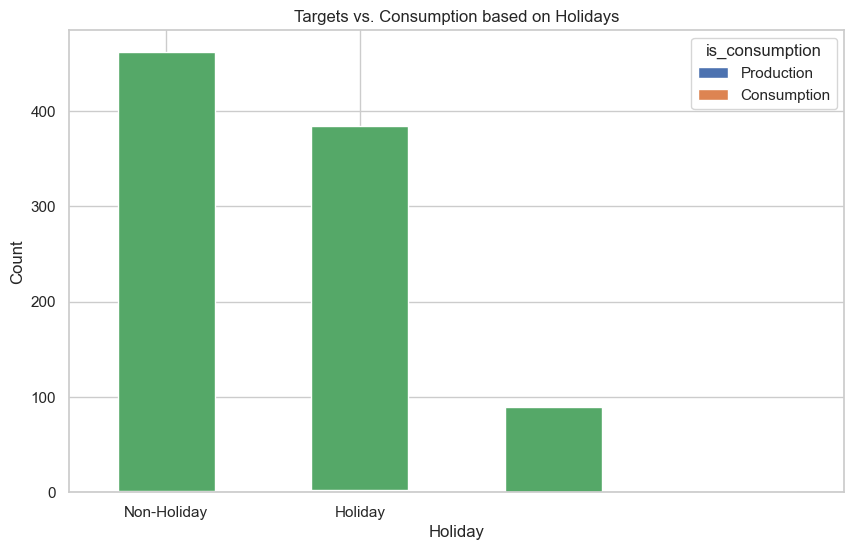

In [16]:
grouped_df = train_df[['holiday', 'is_consumption', 'target']].groupby(['holiday', 'is_consumption'], as_index=False) \
.mean().sort_values(by='target', ascending=False)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
grouped_df.plot(kind='bar', stacked=True, ax=ax)

# Customizing plot
plt.title('Targets vs. Consumption based on Holidays')
plt.xlabel('Holiday')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)

# Adding legend
plt.legend(title='is_consumption', loc='upper right', labels=['Production', 'Consumption'])

plt.show()

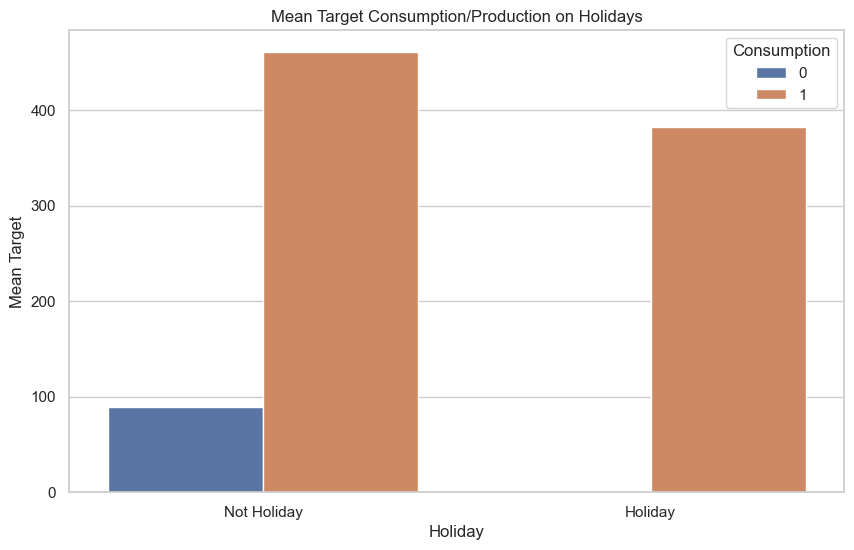

In [19]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='target', hue='is_consumption', data=grouped_df)
plt.title('Mean Target Consumption/Production on Holidays')
plt.xlabel('Holiday')
plt.ylabel('Mean Target')
plt.xticks([0, 1], ['Not Holiday', 'Holiday'])
plt.legend(title='Consumption', loc='upper right')
plt.show()

In [21]:
train_df['holiday'].sum()

2630

In [23]:
train_df['datetime'].nunique()

15312

In [36]:
abc = train_df[train_df['holiday'] == 1]['datetime'].unique()

# Convert NumPy array to pandas Series
abc_series = pd.Series(abc)

# Extract date component
abc_dates_only = abc_series.dt.date

print(abc_dates_only)


0     2021-09-06
1     2021-10-11
2     2021-11-11
3     2021-11-25
4     2021-12-25
5     2022-01-01
6     2022-01-17
7     2022-02-21
8     2022-05-30
9     2022-06-19
10    2022-07-04
11    2022-09-05
12    2022-10-10
13    2022-11-11
14    2022-11-24
15    2022-12-25
16    2023-01-01
17    2023-01-16
18    2023-02-20
19    2023-05-29
dtype: object
